Calculate a d-score which is the difference in log p-values between the prediction and the actual SV breaks, where the predictions and SV breaks are modeled using known distributions from which the p-value can be calculated. 

## Plotting functions and libraries

In [2]:
library('ggplot2')
library('gridExtra')
library(grid)
library(RColorBrewer)
library(fitdistrplus)
library(actuar)

## Set working directory and figure directories

In [3]:
projectdir="../"
paperfigdir="figures"
supfigdir="figures/supfigures"
setwd(projectdir)

## Plotting functions

In [4]:
add_corner_label <- function(p, letter){
    newp <- arrangeGrob(p, top=textGrob(toupper(letter), x=unit(.05, "npc"), y=unit(0, "npc"), just=c("left", "top")))
    return(newp)
}

In [5]:
make_comp_plots_sv<- function(dat, myxmin=0, myxlim=NULL){
    realcnt <- dat[dat>myxmin]
    if (is.null(myxlim)){
        qnt <- quantile(realcnt, probs=c(0.25,0.5,0.75))
        iqr <- qnt[3]-qnt[1]
        myxlim <- qnt[2] + 6 *iqr
    }
    mycnts <- realcnt[realcnt < myxlim]
    fl <- fitdist(mycnts, "lnorm", method="mle")
    fll <- fitdist(mycnts, "llogis", method="mle")
    fg <- fitdist(mycnts, "gamma", method="mle")
    fn <- fitdist(mycnts, "norm", method="mle")
    fe <- fitdist(mycnts, "exp", method="mle")

    myfits = list(fl, fll, fg, fn, fe)
    plot.legend=c("lognormal", "loglogistic", "gamma", "normal", "exponential")
    stats=gofstat(myfits, fitnames=plot.legend)
    # make the fitted distribution in order of best fit and add the BIC to the legend. 
    mybic=stats$bic
    oi <- seq(length(myfits)) # don't change the order. order(stats$bic)
    myfits <- myfits[oi]
    plot.legend <- plot.legend[oi]
    mybic=stats$bic[oi]
    legendnames=plot.legend
    for (i in seq_along(myfits)){
        legendnames[i] <- paste0(plot.legend[i], " (", format(mybic[i], digits=4, scientific=TRUE), ")")
    }
    mycols=brewer.pal(length(myfits), "Set1")
    mylwd=1.5
    myxlim=c(0,myxlim)
    dp <- denscomp(myfits, legendtext = plot.legend, fitcol=mycols, lwd=mylwd, xlim=myxlim, plotstyle="ggplot")
    dp <- dp + labs(x="SV breakpoints", title="Histogram") + 
        theme(plot.title=element_text(size=11), axis.title=element_text(size=10), axis.text=element_text(size=7))
    qp <- qqcomp(myfits, legendtext = legendnames, fitcol=mycols, fitpch=c(1:4), lwd=mylwd, xlim=myxlim, plotstyle="ggplot")
    qp <- qp + theme(plot.title=element_text(size=11), axis.title=element_text(size=10), axis.text=element_text(size=7))
    return(list(dp, qp))
}

make_comp_plots_dsb<- function(dat, myxmin=0, myxlim=NULL){
    realcnt <- dat[dat>myxmin]
    if (is.null(myxlim)){
        qnt <- quantile(realcnt, probs=c(0.25,0.5,0.75))
        iqr <- qnt[3]-qnt[1]
        myxlim <- qnt[2] + 6 *iqr
    }
    mycnts <- realcnt[realcnt < myxlim]
    fl <- fitdist(mycnts, "lnorm", method="mle")
    fll <- fitdist(mycnts, "llogis", method="mle")
    fg <- fitdist(mycnts, "gamma", method="mle")
    fn <- fitdist(mycnts, "norm", method="mle")
    fe <- fitdist(mycnts, "exp", method="mle")
    myfits = list(fl, fll, fg, fn, fe)
    plot.legend=c("lognormal", "loglogistic", "gamma", "normal", "exponential")
    stats=gofstat(myfits, fitnames=plot.legend)
    # make the fitted distribution in order of best fit and add the BIC to the legend. 
    mybic=stats$bic
    oi <- seq(length(myfits)) # don't change the order. order(stats$bic)
    myfits <- myfits[oi]
    plot.legend <- plot.legend[oi]
    mybic=stats$bic[oi]
    legendnames=plot.legend
    for (i in seq_along(myfits)){
        legendnames[i] <- paste0(plot.legend[i], " (", format(mybic[i], digits=4, scientific=TRUE), ")")
    }
    mycols=brewer.pal(length(myfits), "Set1")
    mylwd=1.5
    myxlim=c(0,myxlim)
    dp <- denscomp(myfits, legendtext = plot.legend, fitcol=mycols, lwd=mylwd, xlim=myxlim, plotstyle="ggplot")
    dp <- dp + labs(x="Predicted DSB", title="Histogram") + 
        theme(plot.title=element_text(size=11), axis.title=element_text(size=10), axis.text=element_text(size=7))
    qp <- qqcomp(myfits, legendtext = legendnames, fitcol=mycols, fitpch=c(1:4), lwd=mylwd, xlim=myxlim, plotstyle="ggplot")
    qp <- qp +
        theme(plot.title=element_text(size=11), axis.title=element_text(size=10), axis.text=element_text(size=7))
    return(list(dp, qp))
}

In [6]:
make_comp_plots_dscores<- function(mydat, cntmin=1, dsbmin=0, myxmin=NULL, myxlim=NULL){
    dat=mydat$dscore
    realcnt=dat[mydat$realcnt >= cntmin & mydat$predicted >= dsbmin]
    if (is.null(myxlim)){
        qnt <- quantile(realcnt, probs=c(0.25,0.5,0.75), na.rm=TRUE)
        iqr <- qnt[3]-qnt[1]
        myxlim <- qnt[2] + 6 *iqr
        myxmin <- qnt[2] - 6 *iqr
    }
    mycnts <- realcnt[realcnt < myxlim & realcnt > myxmin]
    ft <- fitdist(mycnts, "t", start=list(df=4), method="mle")
    fn <- fitdist(mycnts, "norm", method="mle")
    fc <- fitdist(mycnts, "cauchy", method="mle")
    myfits = list(ft, fn, fc)
    plot.legend=c("student-t", "normal", "Cauchy")
    stats=gofstat(myfits, fitnames=plot.legend)
    # make the fitted distribution in order of best fit and add the BIC to the legend. 
    mybic=stats$bic
    oi <- seq(length(myfits)) # don't change the order. order(stats$bic)
    myfits <- myfits[oi]
    plot.legend <- plot.legend[oi]
    mybic=stats$bic[oi]
    legendnames=plot.legend
    for (i in seq_along(myfits)){
        legendnames[i] <- paste0(plot.legend[i], " (", format(mybic[i], digits=4, scientific=TRUE), ")")
    }
    mycols=brewer.pal(length(myfits), "Set1")
    mylwd=1.5
    myxlim=c(myxmin,myxlim)
    dp <- denscomp(myfits, legendtext = plot.legend, fitcol=mycols, lwd=mylwd, xlim=myxlim, plotstyle="ggplot")
    dp <- dp + labs(x="d-score", title="Histogram") + 
        theme(plot.title=element_text(size=11), axis.title=element_text(size=10), axis.text=element_text(size=7))
    qp <- qqcomp(myfits, legendtext = legendnames, fitcol=mycols, fitpch=c(1:4), lwd=mylwd, xlim=myxlim, plotstyle="ggplot")
    qp <- qp + theme(plot.title=element_text(size=11), axis.title=element_text(size=10), axis.text=element_text(size=7))
    return(list(dp, qp))
}

# FigureS9: SV distribution fits

In [7]:
make_comp_plots_sv2 <- function(realcnts, title="Title", lab1="a", lab2="b") {
    plts <- make_comp_plots_sv(dat=realcnts, myxmin=1, myxlim=NULL)
    dp <- plts[[1]]
    dp <- dp + theme(legend.position="none")
    dp <- add_corner_label(dp, lab1)
    qp <- add_corner_label(plts[[2]], lab2)

    gf <- arrangeGrob(grobs=list(dp, qp), ncol=2, widths=c(.8,1.5), 
                 top=textGrob(title, x=unit(2, "lines"), y=unit(0, "lines"), just=c("left", "top")))
    return(gf)

}

In [8]:
realcnts=read.table("data/cancer_SVcnts/icgc/carc_realcnts.txt", header=TRUE)
realcnts <- realcnts$any
picgc_carc <- make_comp_plots_sv2(realcnts, title="ICGC_CARC", lab1="a", lab2="b")

Warning message in hist.default(mydata, plot = FALSE, ...):
“argument ‘...’ is not made use of”

In [9]:
realcnts=read.table("data/cancer_SVcnts/icgc/brca_realcnts.txt", header=TRUE)
realcnts <- realcnts$any
picgc_brca <- make_comp_plots_sv2(realcnts, title="ICGC_BRCA", lab1="c", lab2="d")

Warning message in hist.default(mydata, plot = FALSE, ...):
“argument ‘...’ is not made use of”

In [10]:
realcnts=read.table("data/cancer_SVcnts/tcga/tcga_bytype_realcnts.txt", header=TRUE)
realcnts <- realcnts[,which(colnames(realcnts)=="TCGA.SCCA.all")]
ptcga_scca <- make_comp_plots_sv2(realcnts, title="TCGA_SCCA", lab1="e", lab2="f")

Warning message in hist.default(mydata, plot = FALSE, ...):
“argument ‘...’ is not made use of”

In [11]:
realcnts=read.table("data/cancer_SVcnts/tcga/tcga_bytype_realcnts.txt", header=TRUE)
realcnts <- realcnts[,which(colnames(realcnts)=="TCGA.BRCA.all")]
ptcga_brca <- make_comp_plots_sv2(realcnts, title="TCGA_BRCA", lab1="g", lab2="h")

Warning message in hist.default(mydata, plot = FALSE, ...):
“argument ‘...’ is not made use of”

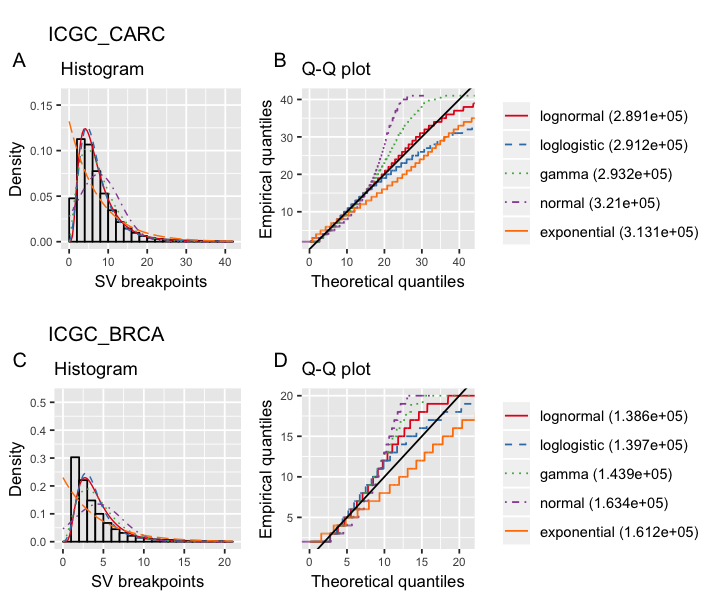

In [12]:
options(repr.plot.width=6, repr.plot.height=5)
gf <- arrangeGrob(picgc_carc, picgc_brca, nrow=2)
grid.arrange(gf)

In [13]:
ggsave(file="SupFigure13_sv_fits_v2.png", plot=gf, path=supfigdir, width=6, height=5, units="in", dpi=600)
ggsave(file="SupFigure13_sv_fits_v2.pdf", plot=gf, path=supfigdir, width=6, height=5, units="in", dpi=600)

# FigureS10: DSB distribution fits

In [14]:
make_comp_plots_dsb2 <- function(preddat, myxmin=0, title="Title", lab1="a", lab2="b") {
    plts <- make_comp_plots_dsb(dat=preddat, myxmin=myxmin, myxlim=NULL)
    dp <- plts[[1]]
    dp <- dp + theme(legend.position="none")
    dp <- add_corner_label(dp, lab1)
    qp <- add_corner_label(plts[[2]], lab2)

    gf <- arrangeGrob(grobs=list(dp, qp), ncol=2, widths=c(.8,1.5), 
                 top=textGrob(title, x=unit(2, "lines"), y=unit(0, "lines"), just=c("left", "top")))
    return(gf)

}

In [15]:
preddat=read.table("data/randforest_results/NHEK_BREAK/predicted.txt", header=TRUE)
pnhek <- make_comp_plots_dsb2(preddat=preddat$predicted, myxmin=0.75, title="NHEK", lab1="a", lab2="b")

Warning message in hist.default(mydata, plot = FALSE, ...):
“argument ‘...’ is not made use of”

In [16]:
preddat=read.table("data/randforest_results/K562_BLISS/predicted.txt", header=TRUE)
pred=preddat$predicted * 10000
pk562 <- make_comp_plots_dsb2(preddat=pred, myxmin=0.5, title="K562", lab1="c", lab2="d")

Warning message in hist.default(mydata, plot = FALSE, ...):
“argument ‘...’ is not made use of”

In [17]:
preddat=read.table("data/randforest_results/MCF7_BLISS/predicted.txt", header=TRUE)
pred=preddat$predicted * 10000
pmcf7 <- make_comp_plots_dsb2(preddat=pred, myxmin=0.5, title="MCF7", lab1="e", lab2="f")

Warning message in hist.default(mydata, plot = FALSE, ...):
“argument ‘...’ is not made use of”

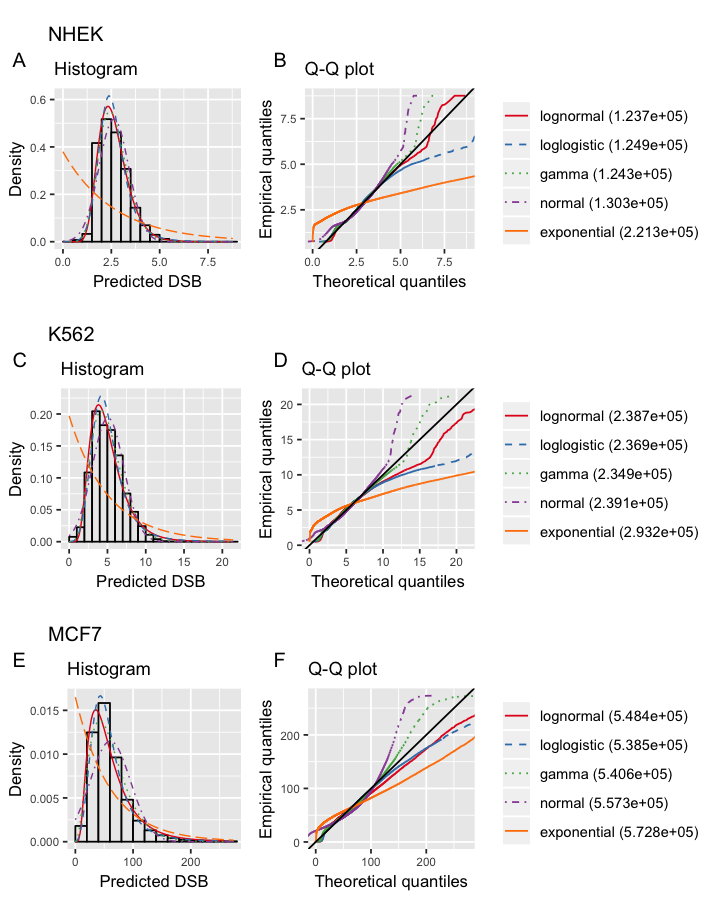

In [18]:
options(repr.plot.width=6, repr.plot.height=7.5)
gf <- arrangeGrob(pnhek, pk562, pmcf7, nrow=3)
grid.arrange(gf)

In [19]:
ggsave(file="SupFigure14_dsb_fits_v2.png", plot=gf, path=supfigdir, width=6, height=7.5, units="in", dpi=600)
ggsave(file="SupFigure14_dsb_fits_v2.pdf", plot=gf, path=supfigdir, width=6, height=7.5, units="in", dpi=600)

# FigureS11: Dscore distribution fits

In [20]:
make_comp_plots_dscores2 <- function(ct, sv, pvalsdir="data/dscores/", cntmin=1, dsbmin=0.5, lab1="a", lab2="b"){
    ddat=read.table(paste0(pvalsdir, ct, ".", sv, ".dlogp.txt"), header=TRUE)
    plts <- make_comp_plots_dscores(mydat=ddat, cntmin=cntmin, dsbmin=dsbmin)
    dp <- plts[[1]]
    dp <- dp + theme(legend.position="none")
    dp <- add_corner_label(dp, lab1)
    qp <- add_corner_label(plts[[2]], lab2)
    p <- arrangeGrob(grobs=list(dp, qp), ncol=2, widths=c(.8,1.5),
        top=textGrob(paste(toupper(ct),toupper(sv)), 
              x=unit(2, "lines"), y=unit(0, "lines"), just=c("left", "top")))
     return(p)
}

In [21]:
p1 <- make_comp_plots_dscores2(ct="nhek", sv="icgc_carc", cntmin=1, dsbmin=0.5, lab1="a", lab2="b")

Warning message in hist.default(mydata, plot = FALSE, ...):
“argument ‘...’ is not made use of”

In [22]:
p2 <- make_comp_plots_dscores2(ct="mcf7", sv="icgc_brca", cntmin=1, dsbmin=0.001, lab1="c", lab2="d")

Warning message in hist.default(mydata, plot = FALSE, ...):
“argument ‘...’ is not made use of”

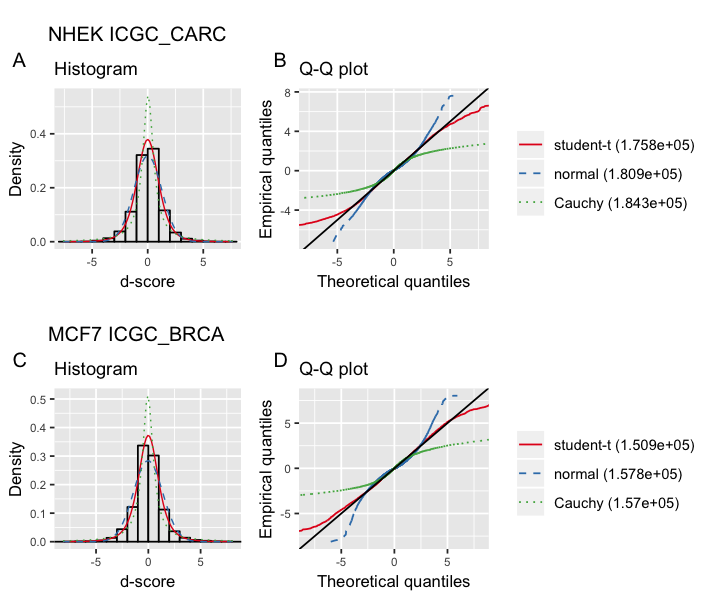

In [23]:
options(repr.plot.width=6, repr.plot.height=5)
gf <- arrangeGrob(p1, p2, nrow=2)
grid.arrange(gf)

In [24]:
ggsave(file="SupFigure15_dscore_fits.png", plot=gf, path=supfigdir, width=6, height=5, units="in", dpi=600)
ggsave(file="SupFigure15_dscore_fits.pdf", plot=gf, path=supfigdir, width=6, height=5, units="in", dpi=600)